<a href="#1-Definitions" style="margin-left: 0px;">1 Definitions</a>  <br>
<a href="#1.1-Activation-functions" style="margin-left: 20px;">1.1 Activation functions</a>  <br>
<a href="#1.2-Types-of-recurrent-neural-networks" style="margin-left: 20px;">1.2 Types of recurrent neural networks</a>  <br>

<a href="#2-Simple-RNN" style="margin-left: 0px;">2 Simple RNN</a>  <br>

<a href="#3-GRU-(Gated-recurrent-unit)" style="margin-left: 0px;">3 GRU (Gated recurrent unit)</a>  <br>

<a href="#4-LSTM-(Long-Short-Term-Memory)" style="margin-left: 0px;">4 LSTM (Long Short Term Memory)</a>


### 1 Definitions

**Рекуррентная нейронная сеть (РНС, англ. Recurrent Neural Network, RNN)** — это тип искусственной нейронной сети, предназначенный для обработки последовательностей данных, где важна зависимость между элементами

### 1.1 Activation functions

Часто используют: Tanh, sigmoid, and softmax.

### 1.2 Types of recurrent neural networks

#### 1. One-to-Many (Один ко многим)
Один вход — несколько выходов.

Генерация изображения по текстовому описанию (например, нейросеть создает картину на основе одного текстового запроса).   
Синтез речи по тексту (из одной текстовой строки модель генерирует последовательность аудиофрагментов).  

#### 2. Many-to-Many (Многие ко многим)
Несколько входов — несколько выходов.

Машинный перевод (например, перевод предложения с русского на английский: модель принимает последовательность слов и генерирует новую последовательность слов).  
Видеоклассификация по кадрам (анализ видеопотока, где каждый кадр влияет на прогноз, а выход — последовательность меток).  

#### 3. Many-to-One (Многие к одному)
Несколько входов — один выход.

Анализ тональности текста (вход — последовательность слов, выход — одно значение: положительный/отрицательный/нейтральный).  
Распознавание эмоций по аудиозаписи (модель анализирует последовательность звуковых фрагментов и выдает одну эмоцию).  

### 2 Simple RNN

#### The architecture of a recurrent neural network

1) $x_{1},x_{2},...,x_{n}$ - входы  
2) Есть вектор $h$, в начале обычно подают $\bar{h}_{0} = [0,...,0_{N}]^{T}$  
3) Эти два вектора подаются на рекурентный слой $φ$       
4) проходя через рекурентный слой $φ$ получаем вектор $\bar{h}_{t-1}$     
$\bar{h}_{t} = φ(\bar{h}_{t-1},\bar{x})$, где $φ$ - функция активации   
5) На выходной слой мы подаем сумму произведений весов $W_{i}$ и значений векторов $\bar{h_{i}}_{t}$  
6) Вектор $y = [y_{1},...,y_{M}]$  равен значению функции активации от этих значений: $\bar{y_{i}} = f(\sum\limits_{i=1}^{n}W_{i}h_{i})$  

#### На самом деле обычно подаются батчи 1-х букв, например, эмбеддинг буквы будет иметь размер 15, а батч будет 32, тогда на вход будет подаваться тензор рзамером [32 x 15]

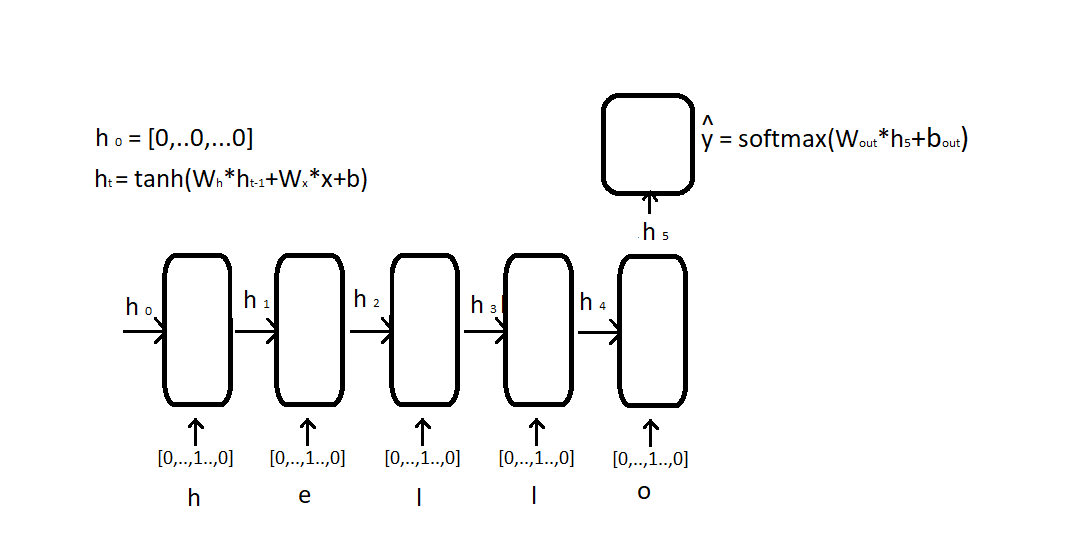

In [1]:
from IPython.display import display, Image

display(Image("Images/1 RNN.png"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
import random
import math
import json
import ast

In [3]:
data = pd.read_csv(r"../00 Data/babynames-clean.csv")

# Почему то некоторые списки при сохранении переводит в строки, поэтому делаю так:
data["tokenized_Name"] = data["tokenized_Name"].apply(ast.literal_eval)

print(data.shape)
data

(6782, 4)


,Name,Gender,padded_Name,tokenized_Name
0,john,0,<SOS>john<EOS>,"[0, 10, 15, 8, 14, 27, 28, 28, 28, 28, 28, 28,..."
1,william,0,<SOS>william<EOS>,"[0, 23, 9, 12, 12, 9, 1, 13, 27, 28, 28, 28, 28]"
2,james,0,<SOS>james<EOS>,"[0, 10, 1, 13, 5, 19, 27, 28, 28, 28, 28, 28, 28]"
3,charles,0,<SOS>charles<EOS>,"[0, 3, 8, 1, 18, 12, 5, 19, 27, 28, 28, 28, 28]"
4,george,0,<SOS>george<EOS>,"[0, 7, 5, 15, 18, 7, 5, 27, 28, 28, 28, 28, 28]"
...,...,...,...,...
6777,laylah,1,<SOS>laylah<EOS>,"[0, 12, 1, 25, 12, 1, 8, 27, 28, 28, 28, 28, 28]"
6778,carleigh,1,<SOS>carleigh<EOS>,"[0, 3, 1, 18, 12, 5, 9, 7, 8, 27, 28, 28, 28]"
6779,kenley,1,<SOS>kenley<EOS>,"[0, 11, 5, 14, 12, 5, 25, 27, 28, 28, 28, 28, 28]"
6780,sloane,1,<SOS>sloane<EOS>,"[0, 19, 12, 15, 1, 14, 5, 27, 28, 28, 28, 28, 28]"


In [4]:
# Видим что есть пробелы после <EOS>
data["padded_Name"].iloc[0]

'<SOS>john<EOS>       '

In [5]:
# Загрузка обратно
with open("../00 Data/id_to_token.json", "r", encoding="utf-8") as f:
    id_to_token = json.load(f)
    
# Создаем обратный словарь
token_to_id = {token: id_ for id_, token in id_to_token.items()}

In [6]:
id_to_token

{'0': '<SOS>',
 '1': 'a',
 '2': 'b',
 '3': 'c',
 '4': 'd',
 '5': 'e',
 '6': 'f',
 '7': 'g',
 '8': 'h',
 '9': 'i',
 '10': 'j',
 '11': 'k',
 '12': 'l',
 '13': 'm',
 '14': 'n',
 '15': 'o',
 '16': 'p',
 '17': 'q',
 '18': 'r',
 '19': 's',
 '20': 't',
 '21': 'u',
 '22': 'v',
 '23': 'w',
 '24': 'x',
 '25': 'y',
 '26': 'z',
 '27': '<EOS>',
 '28': ' '}

In [7]:
token_to_id

{'<SOS>': '0',
 'a': '1',
 'b': '2',
 'c': '3',
 'd': '4',
 'e': '5',
 'f': '6',
 'g': '7',
 'h': '8',
 'i': '9',
 'j': '10',
 'k': '11',
 'l': '12',
 'm': '13',
 'n': '14',
 'o': '15',
 'p': '16',
 'q': '17',
 'r': '18',
 's': '19',
 't': '20',
 'u': '21',
 'v': '22',
 'w': '23',
 'x': '24',
 'y': '25',
 'z': '26',
 '<EOS>': '27',
 ' ': '28'}

#### Подготовим данные

In [8]:
# Разделение на обучающую (80%), валидационную (10%) и тестовую (10%) выборки
train, temp = train_test_split(data, test_size=0.2, stratify=data['Gender'], random_state=42)  # 80% для обучения
valid, test = train_test_split(temp, test_size=0.5, stratify=temp['Gender'], random_state=42)  # 10% для валидации и 10% для теста

In [9]:
# Выводим результаты
print("Train set:")
print(train["Gender"].value_counts().sort_index())
print("\nValidation set:")
print(valid["Gender"].value_counts().sort_index())
print("\nTest set:")
print(test["Gender"].value_counts().sort_index())

Train set:
Gender
0    2749
1    2676
Name: count, dtype: int64

Validation set:
Gender
0    344
1    334
Name: count, dtype: int64

Test set:
Gender
0    344
1    335
Name: count, dtype: int64


In [10]:
class NameDataset(Dataset):
    def __init__(self, df):
        self.names = df['tokenized_Name'].tolist()  # Последовательности токенов
        self.genders = df['Gender'].tolist()  # Таргеты (0 или 1)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = torch.tensor(self.names[idx], dtype=torch.long)  # Преобразуем в Tensor
        length = torch.tensor(len(self.names[idx]), dtype=torch.long)
        gender = torch.tensor(self.genders[idx], dtype=torch.long)  # Целевая переменная
        return name, length, gender

In [11]:
batch_size = 32
train_dataset = NameDataset(train)
valid_dataset = NameDataset(valid)
test_dataset = NameDataset(test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# пример одного элемента train_loader
for name, length, gender in train_loader:
    print("name: ",name,"\n")
    print("length: ",length,"\n")
    print("gender: ",gender,"\n")
    break

name:  tensor([[ 0, 10, 15, 19,  5,  6, 27, 28, 28, 28, 28, 28, 28],
        [ 0,  1, 18,  4, 25,  3,  5, 27, 28, 28, 28, 28, 28],
        [ 0, 10,  1,  3, 17, 21,  5, 26, 27, 28, 28, 28, 28],
        [ 0,  1, 25,  5, 19,  8,  1, 27, 28, 28, 28, 28, 28],
        [ 0, 14,  5, 12, 12, 15, 27, 28, 28, 28, 28, 28, 28],
        [ 0,  7,  5, 15, 18,  7,  5,  1, 14, 14, 27, 28, 28],
        [ 0, 15, 18, 22,  9, 12, 27, 28, 28, 28, 28, 28, 28],
        [ 0,  1, 19,  8,  5, 18, 27, 28, 28, 28, 28, 28, 28],
        [ 0, 20,  1, 12,  9, 25,  1,  8, 27, 28, 28, 28, 28],
        [ 0, 18, 15,  3, 11, 27, 28, 28, 28, 28, 28, 28, 28],
        [ 0, 11, 25, 19, 15, 14, 27, 28, 28, 28, 28, 28, 28],
        [ 0,  8,  5, 20, 20,  9,  5, 27, 28, 28, 28, 28, 28],
        [ 0, 11,  9, 13,  2,  5, 18,  5, 12, 25, 27, 28, 28],
        [ 0, 22,  5,  4,  1, 27, 28, 28, 28, 28, 28, 28, 28],
        [ 0, 10, 15, 22,  1, 14,  9, 27, 28, 28, 28, 28, 28],
        [ 0,  6, 18,  5,  4,  5, 18,  9,  3, 27, 28, 28, 28],
 

In [13]:
class NameGenderClassifier_RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(NameGenderClassifier_RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers,nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Бинарная классификация (1 выход)
        self.sigmoid = nn.Sigmoid()  # Применяем сигмоиду для вероятности

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return torch.sigmoid(out)  # <-- Добавляем сигмоиду!

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Гиперпараметры
vocab_size = len(id_to_token)
embedding_dim = 5#13
hidden_size = 5
num_layers = 1
num_epochs = 10  # Количество эпох
learning_rate = 0.001

# Создаем модель
model_RNN = NameGenderClassifier_RNN(vocab_size, embedding_dim, hidden_size, num_layers).to(device)
criterion = nn.BCELoss()  # Бинарная кросс-энтропия
optimizer = optim.Adam(model_RNN.parameters(), lr=learning_rate)

In [15]:
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for name, length, gender in train_loader:
        name = name.to(device)
        gender = gender.float().to(device)  # Переводим в float, так как BCE требует float-метки
        
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model_RNN(name).squeeze()  # (batch_size, 1) -> (batch_size,)
        loss = criterion(outputs, gender)
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем веса
        
        total_loss += loss.item()
        
        # Оценка точности
        predicted = (outputs > 0.5).float()  # Округляем вероятности (0 или 1)
        correct += (predicted == gender).sum().item()
        total += gender.size(0)

    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/10], Loss: 117.5450, Accuracy: 0.5224
Epoch [2/10], Loss: 113.2926, Accuracy: 0.6079
Epoch [3/10], Loss: 106.4296, Accuracy: 0.6630
Epoch [4/10], Loss: 101.5744, Accuracy: 0.6971
Epoch [5/10], Loss: 97.8959, Accuracy: 0.7145
Epoch [6/10], Loss: 95.2550, Accuracy: 0.7301
Epoch [7/10], Loss: 93.2535, Accuracy: 0.7399
Epoch [8/10], Loss: 91.6021, Accuracy: 0.7421
Epoch [9/10], Loss: 90.3951, Accuracy: 0.7499
Epoch [10/10], Loss: 88.8702, Accuracy: 0.7561


In [16]:
def calculate_auc(dataset, model, device):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    all_probs = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in loader:
            names = batch[0].to(device)  # Берём только names (первый элемент)
            # lengths = batch[1]  # Не используется, так как модель не принимает lengths
            genders = batch[2]  # Метки
            
            # Передаём ТОЛЬКО names (модель принимает 1 аргумент)
            outputs = model(names)
            
            # Получаем вероятности (сигмоида уже применена в модели)
            probs = outputs.squeeze()  # Удаляем лишние размерности
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(genders.cpu().numpy())
    
    auc = roc_auc_score(all_labels, all_probs)
    return auc

In [17]:
# Пример использования
train_auc = calculate_auc(train_dataset, model_RNN, device)
valid_auc = calculate_auc(valid_dataset, model_RNN, device)
test_auc = calculate_auc(test_dataset, model_RNN, device)

print(f"Train AUC: {train_auc:.4f}")
print(f"Valid AUC: {valid_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Train AUC: 0.8253
Valid AUC: 0.8149
Test AUC: 0.8297


### Моя реализация Рекуррентного слоя

### Кратко

1) Инициализируем веса у матриц

2) Идем двойным циклом по каждой букве внутри цикла по каждому слою и считаем $h_{t}$

$$
h_t^{(l)} = \sigma\left( x_t \cdot W_{ih}^{(l)^\top} + b_{ih}^{(l)} + h_{t-1}^{(l)} \cdot W_{hh}^{(l)^\top} + b_{hh}^{(l)} \right)
$$


l - номер слоя   
t - номер буквы (время)   
для следуюзего  скрытого слоя вместо $x_{t}$ вход будет h^{l-1}_{t} (то есть выход предыдущего рекуррентного слоя)  

**Когда мы считаем новые $h^{l}_{t}$ наши веса при этом остаются одни и теже от букве к букве, то есть от t-1 до t, но для каждого слоя $W^{l}$ разные**

Прикол в том что мы просто добавляем как "дровишки" новые $x_{t}$ и новые $h_{t-1}^{(l)}$ для подсчёта $h_{t}^{(l)}$, веса в рамках одного слоя для разных времени t остаются одними и теми же, они обновляются только после backward  

То есть по сути мы в рекурентной сети обновляем 6 параметров:  
1) $W^{l}_{ih}$  
2) $b^{l}_{ih}$  
3) $W^{l}_{hh}$  
4) $b^{l}_{hh}$  
5) $W_{out}$  
6) $b_{out}$  

**Проход вперед (Forward) для нескольких слоёв**

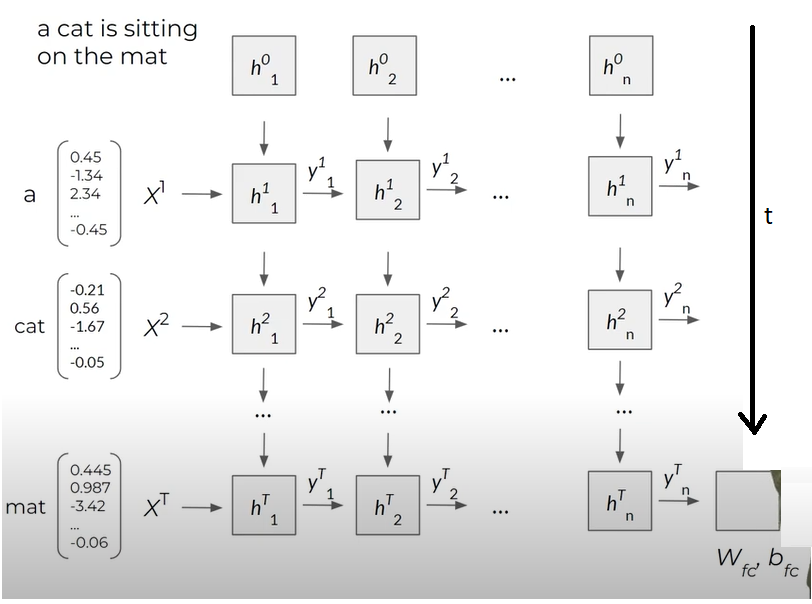

In [18]:
display(Image("Images/3 Many Layers.png"))

**Back Probagation Throug Time**

Для нахождения градиенты мы тянем производную сквозь время назад, поэтому метод называется BBTT  

**Пример с 1-м слоем**

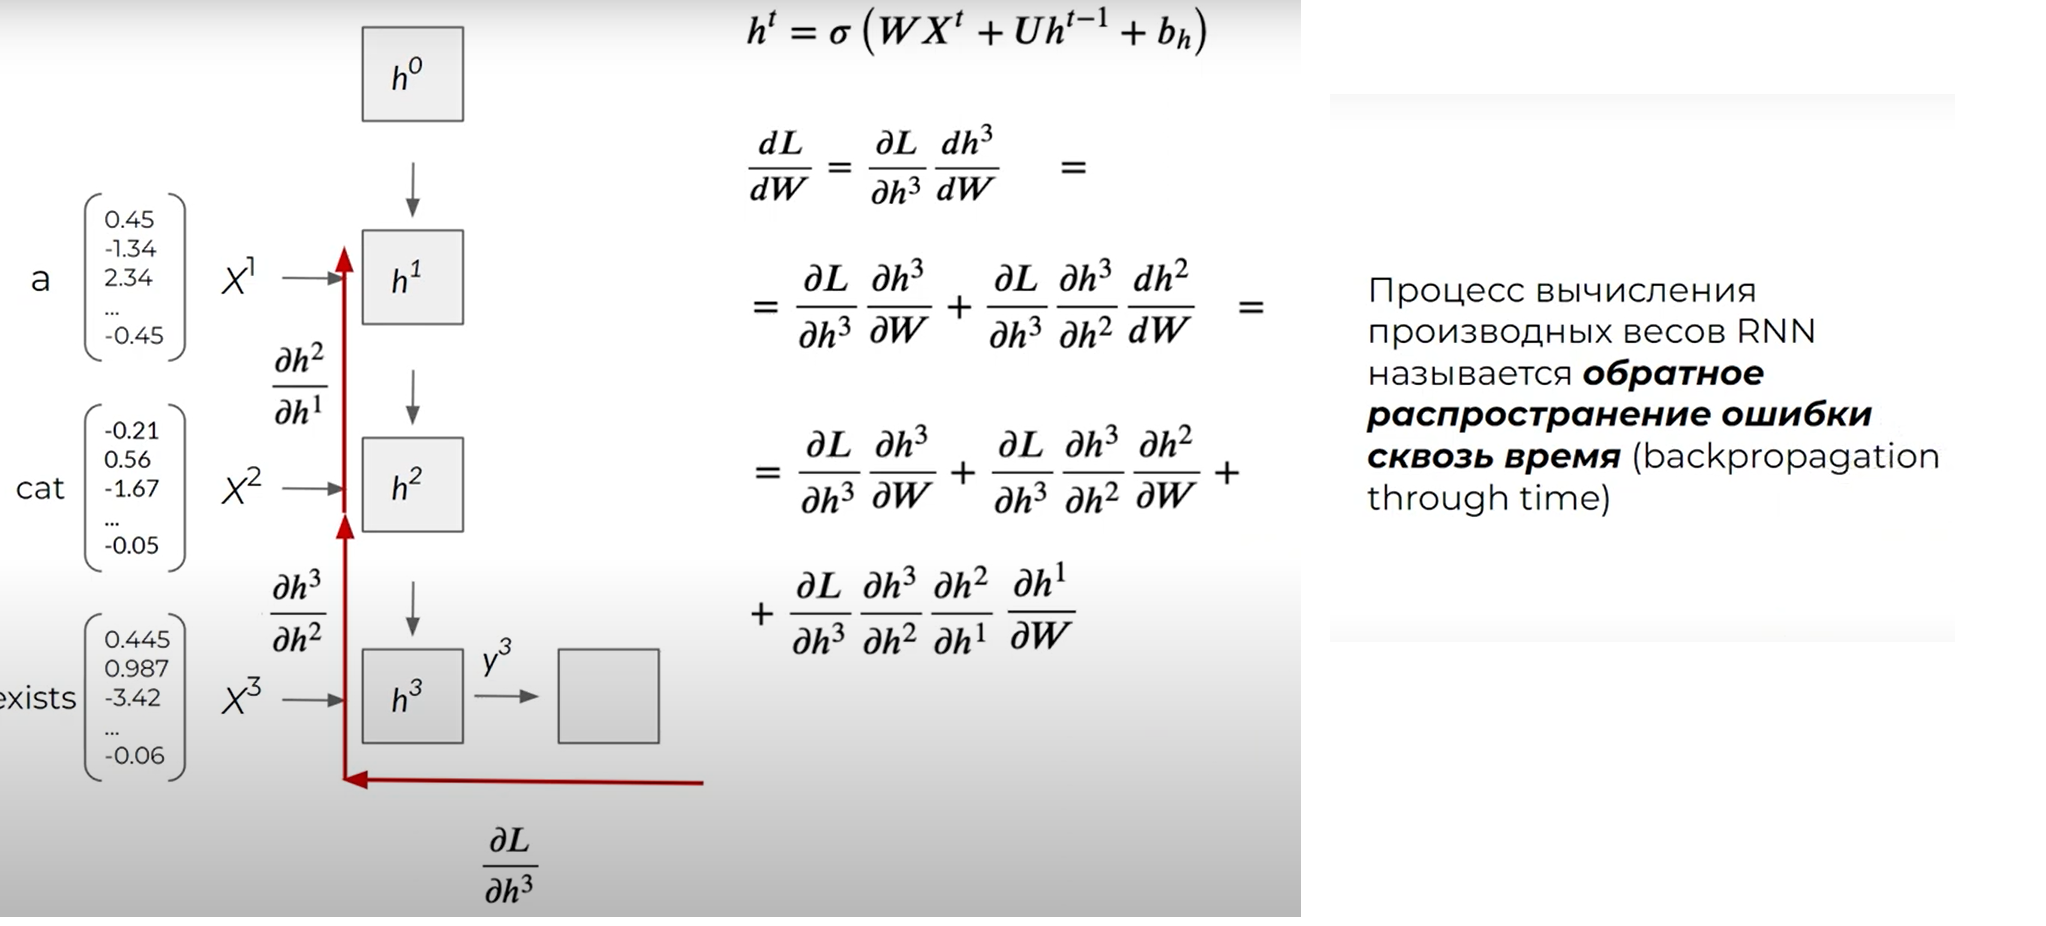

In [19]:
display(Image("Images/2 BackProbagationThrougTime.png"))

### Детально

### 1) Инициализация параметров весов и смещений  

Например, 

hidden_dim = 5 - количество нейронов в сркытом слое  
input_dim = 10 - количество входных признаков  
layer_dim = 3 - количество слоёв RNN   

тогда **self.weight_ih** будут таких размеров: (это список матриц весов входа)   

[  
  torch.Size([5, 10]),  # Веса для 1-го слоя  
  torch.Size([5, 10]),  # Веса для 2-го слоя  
  torch.Size([5, 10])   # Веса для 3-го слоя  
]   

 **self.weight_hh** (это список матриц весов скрытого состояния)  

[  
  torch.Size([5, 5]),  # Веса для 1-го слоя  
  torch.Size([5, 5]),  # Веса для 2-го слоя  
  torch.Size([5, 5])   # Веса для 3-го слоя  
]   


**self.bias_ih**:  

[  
  torch.Size([5]),  # Веса для 1-го слоя  
  torch.Size([5]),  # Веса для 2-го слоя  
  torch.Size([5])   # Веса для 3-го слоя  
]   

**self.bias_hh**:  

[  
  torch.Size([5]),  # Веса для 1-го слоя  
  torch.Size([5]),  # Веса для 2-го слоя  
  torch.Size([5])   # Веса для 3-го слоя  
]   

### 2) forward  

#### 2.1) Переделываем формат входного X   

seq_len - длина слова  
input_dim - это размерность вектора, который эмбеддинг выдал для одной "буквы" (или токена)   
batch_size - размер батча  

**Формат батча:**  

В batch_first=True — данные подаются в формате (batch_size, seq_len, input_dim), что является стандартным для многих случаев.  
В batch_first=False — данные подаются в формате (seq_len, batch_size, input_dim).  
        
if self.batch_first is True:  
    x = x.transpose(0, 1)  # Переводим в формат (seq_len, batch_size, input_dim)

#### Пример тензора с batch_first=True  

x = torch.randn(2, 3, 4)  # (batch_size=2, seq_len=3, input_dim=4)
print(x.shape)  # Выводит: torch.Size([2, 3, 4])

**Пока у нас  тензора с batch_first=Fakse**  

x = [

     [[ 0.5459,  0.3345, -0.1223,  1.2342],  - каждый вектор это буква размером 4 для, которую эмбеддинг сделал)  
      [ 0.9395, -0.5421,  0.3413,  0.2145]], - 2 размер батча batch_size  

     [[-1.5523, -0.1374,  0.3545,  0.4123],  - seq_len = 3 - длина слова
      [-0.5643,  0.9827, -0.8334, -0.4232]],  

     [[ 0.4711,  0.2933, -0.5223,  0.1433],  
      [ 1.2344,  0.1234, -0.3451, -0.9784]]]   

Преобразуем его в формат (seq_len, batch_size, input_dim) если batch_first=True


x_transposed = [

     [[ 0.5459,  0.3345, -0.1223,  1.2342], буква 1    
     [-1.5523, -0.1374,  0.3545,  0.4123],  буква 2   
     [ 0.4711,  0.2933, -0.5223,  0.1433]], буква 3    

    [[ 0.9395, -0.5421,  0.3413,  0.2145],  буква 1   
     [-0.5643,  0.9827, -0.8334, -0.4232],  буква 2   
     [ 1.2344,  0.1234, -0.3451, -0.9784]]  буква 3    
     
 ]  

x_transposed = x.transpose(0, 1)  # (seq_len=3, batch_size=2, input_dim=4)
print(x_transposed.shape)  # Выводит: torch.Size([3, 2, 4])

seq_len, batch_size, _ = x.size() # seq_len, batch_size  

seq_len = 13
batch_size = 32 
_ = 5

#### 2.2) Заполняем h_0 нулями  

if hx is None:  
    hx = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, device=x.device)  
    
    
#### 2.3) Идём циклом по каждому элементу(букве) и по каждому слою 

h_t = hx  # Инициализируем скрытое состояние  
output = []  # Список для хранения скрытых состояний всех временных шагов  

$$
h_t^{(l)} = \sigma\left( x_t \cdot W_{ih}^{(l)^\top} + b_{ih}^{(l)} + h_{t-1}^{(l)} \cdot W_{hh}^{(l)^\top} + b_{hh}^{(l)} \right)
$$

#### Исходные скрытые состояния (обычно инициализируются нулями)  
h_t = [  

    tensor([[0.0, 0.0], [0.0, 0.0]]),  # layer=0    
    tensor([[0.0, 0.0], [0.0, 0.0]])   # layer=1    
]

Для каждой буквы h_t_next = []  

#### t=0
h_new_0 = tanh(x[0] @ W_ih[0].T + b_ih[0] + h_t[0] @ W_hh[0].T + b_hh[0]) # layer=0    
h_new_1 = tanh(h_new_0 @ W_ih[1].T + b_ih[1] + h_t[1] @ W_hh[1].T + b_hh[1]) # layer=1 

#### Обновляем скрытые состояния для t=1  
h_t = [h_new_0, h_new_1]  # ← Важно! Теперь h_t содержит новые значения (старых от предыдущей буквы тут уже нет)    


#### t=1 (используем h_t, которые были обновлены на t=0)
h_new_0 = tanh(x[1] @ W_ih[0].T + b_ih[0] + h_t[0] @ W_hh[0].T + b_hh[0])  # h_t[0] из t=0  
h_new_1 = tanh(h_new_0 @ W_ih[1].T + b_ih[1] + h_t[1] @ W_hh[1].T + b_hh[1])  # h_t[1] из t=0  

#### Теперь h_t снова обновляется (для t=2, если он есть)
h_t = [h_new_0, h_new_1]   

#### output добавляет скрытое состояние последнего слоя для каждой буквы
output.append(h_t[-1])  

### 3) backward

**В рекуррентных нейронных сетях (RNN) веса одинаковы для всех временных шагов, но разные для разных слоев (если сеть многослойная)**  

backward() метод тебе тут самому писать не нужно.

Потому что я унаследовал свой класс от nn.Module, и использую torch.Tensor операции (в том числе @, +, activation, и т.д.).
А значит — автоматическое дифференцирование (autograd) PyTorch всё сделает за тебя.   

Веса RNN (и weight_ih, и weight_hh) не обновляются на каждом временном шаге.  
Они общие для всех шагов и обновляются только один раз за батч — во время обратного прохода (backward())  

Допустим у тебя слово длиной 5 букв (seq_len = 5)   
На каждом шаге t = 0, 1, 2, 3, 4 ты вычисляю   
h_new = активация(x[t] @ weight_ih.T + h_t @ weight_hh.T + bias)   

НО веса weight_ih и weight_hh везде одни и те же!  

### Сам класс

In [20]:
class My_RNN_Layer(nn.Module): # Наследуем от nn.Module — чтобы слой корректно работал в nn.Sequential или при обучении.
    def __init__(self, input_dim, hidden_dim, layer_dim=1, batch_first=True, nonlinearity='tanh'):
        super(My_RNN_Layer, self).__init__()
        
        self.input_dim = input_dim  # Количество входных признаков
        self.hidden_dim = hidden_dim  # Размер скрытого состояния (количество нейронов в рекуррентном слое)
        self.layer_dim = layer_dim  # Количество слоев RNN
        self.batch_first = batch_first  # Если True, (batch, seq, feature), иначе (seq, batch, feature)
        self.nonlinearity = nonlinearity  # 'tanh' или 'relu'

        # 1 Инициализация параметров весов и смещений
        # torch.randn() генерирует тензор со значениями, взятыми из стандартного нормального распределения
        # mean = 0 std = 1
        
        # список длиной layer_dim матриц hidden_dim x input_dim (количество слоёв x количество нейронов x количество признаков)
        self.weight_ih = nn.ParameterList([nn.Parameter(torch.randn(hidden_dim, input_dim)) for _ in range(layer_dim)])
        
        # список длиной hidden_dim матриц input_dim (количество слоёв x количество нейронов x количество нейронов)
        self.weight_hh = nn.ParameterList([nn.Parameter(torch.randn(hidden_dim, hidden_dim)) for _ in range(layer_dim)])
        
        # список длиной layer_dim тензоров hidden_dim (количество слоёв x количество нейронов)
        self.bias_ih = nn.ParameterList([nn.Parameter(torch.zeros(hidden_dim)) for _ in range(layer_dim)])
        
        # список длиной layer_dim тензоров hidden_dim (количество слоёв x количество нейронов)
        self.bias_hh = nn.ParameterList([nn.Parameter(torch.zeros(hidden_dim)) for _ in range(layer_dim)])

        
        # Используем Xavier для weight_ih и weight_hh
        # Этот код переопределяет значения в параметрах, создавая более удачную инициализацию.
        # init.xavier_uniform_ (или torch.nn.init.xavier_uniform_) — это метод инициализации весов, 
        # который помогает избежать проблем с градиентами (взрыв/затухание градиента) в нейросетях.
        # Он использует равномерное распределение со специальным масштабом, зависящим от числа входов и выходов нейрона.
        for i in range(self.layer_dim):
            init.xavier_uniform_(self.weight_ih[i])  # Инициализация Xavier для входных весов
            init.xavier_uniform_(self.weight_hh[i])  # Инициализация Xavier для скрытых весов

        # Инициализация смещений нулями
        # init.zeros_ просто заполняет тензоры нулями.
        for i in range(self.layer_dim):
            init.zeros_(self.bias_ih[i])
            init.zeros_(self.bias_hh[i])
        
        
        # Выбираем активацию
        if nonlinearity == 'tanh':
            self.activation = torch.tanh
        elif nonlinearity == 'relu':
            self.activation = torch.relu
        else:
            raise ValueError("Nonlinearity must be 'tanh' or 'relu'")

    def forward(self, x, hx=None): # при помощи матриц считаем значения h_t
        
        # В batch_first=True — данные подаются в формате (batch_size, seq_len, input_dim), что является стандартным для многих случаев.
        # В batch_first=False — данные подаются в формате (seq_len, batch_size, input_dim).
        if self.batch_first is True:
            x = x.transpose(0, 1)  # Переводим в формат (seq_len, batch_size, input_dim)
        
        seq_len, batch_size, _ = x.size() # seq_len, batch_size

        if hx is None:
            hx = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, device=x.device)

        h_t = hx  # Инициализируем скрытое состояние
        output = []  # Список для хранения скрытых состояний всех временных шагов

        for t in range(seq_len): # длина слова (13 у нас)
            h_t_next = []
            for layer in range(self.layer_dim): # идём по всем слоям
                h_new = self.activation(
                    x[t] @ self.weight_ih[layer].T + self.bias_ih[layer] +
                    h_t[layer] @ self.weight_hh[layer].T + self.bias_hh[layer]
                )
                h_t_next.append(h_new)
            h_t = torch.stack(h_t_next)  # Обновляем скрытые состояния
            output.append(h_t[-1])  # Берем последнее скрытое состояние

        output = torch.stack(output)  # Формируем выходной тензор

        if self.batch_first:
            output = output.transpose(0, 1)  # Возвращаем в формат (batch, seq, hidden)

        return output, h_t

    def parameters(self):
        return list(self.weight_ih) + list(self.weight_hh) + list(self.bias_ih) + list(self.bias_hh)

    def load_state_dict(self, state_dict):
        self.load_state_dict(state_dict)

    def initial_hidden_state(self, batch_size):
        return torch.zeros(self.layer_dim, batch_size, self.hidden_dim)

In [21]:
class My_NameGenderClassifier_RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(My_NameGenderClassifier_RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim=5)
        self.rnn = My_RNN_Layer(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Бинарная классификация (1 выход)
        self.sigmoid = nn.Sigmoid()  # Применяем сигмоиду для вероятности

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return torch.sigmoid(out)  # <-- Добавляем сигмоиду!

In [22]:
# Гиперпараметры
vocab_size = len(id_to_token)
embedding_dim = 5#13
hidden_size = 5
num_layers = 1
num_epochs = 10  # Количество эпох
learning_rate = 0.001

# Создаем модель
My_model_RNN = My_NameGenderClassifier_RNN(vocab_size, embedding_dim, hidden_size, num_layers).to(device)
criterion = nn.BCELoss()  # Бинарная кросс-энтропия
optimizer = optim.Adam(My_model_RNN.parameters(), lr=learning_rate)

In [23]:
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for name, length, gender in train_loader:
        name = name.to(device)
        gender = gender.float().to(device)  # Переводим в float, так как BCE требует float-метки
        
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = My_model_RNN(name).squeeze()  # (batch_size, 1) -> (batch_size,)
        loss = criterion(outputs, gender)
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем веса
        
        total_loss += loss.item()
        
        # Оценка точности
        predicted = (outputs > 0.5).float()  # Округляем вероятности (0 или 1)
        correct += (predicted == gender).sum().item()
        total += gender.size(0)

    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/10], Loss: 117.9719, Accuracy: 0.5088
Epoch [2/10], Loss: 117.8261, Accuracy: 0.5171
Epoch [3/10], Loss: 117.7821, Accuracy: 0.5025
Epoch [4/10], Loss: 117.7549, Accuracy: 0.5100
Epoch [5/10], Loss: 117.6811, Accuracy: 0.5272
Epoch [6/10], Loss: 117.6716, Accuracy: 0.5224
Epoch [7/10], Loss: 117.5880, Accuracy: 0.5276
Epoch [8/10], Loss: 117.3836, Accuracy: 0.5272
Epoch [9/10], Loss: 116.8238, Accuracy: 0.5742
Epoch [10/10], Loss: 114.8721, Accuracy: 0.6061


In [24]:
# Пример использования
train_auc = calculate_auc(train_dataset, My_model_RNN, device)
valid_auc = calculate_auc(valid_dataset, My_model_RNN, device)
test_auc = calculate_auc(test_dataset, My_model_RNN, device)

print(f"Train AUC: {train_auc:.4f}")
print(f"Valid AUC: {valid_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Train AUC: 0.6118
Valid AUC: 0.5875
Test AUC: 0.6173


####  Реализованный RNN слой показал схожую производительность и время рассёта

### 3 GRU (Gated recurrent unit)

#### Все равно есть проблема забывания

#### Всего 1 вектор скрытого состояния $h_{t}$  

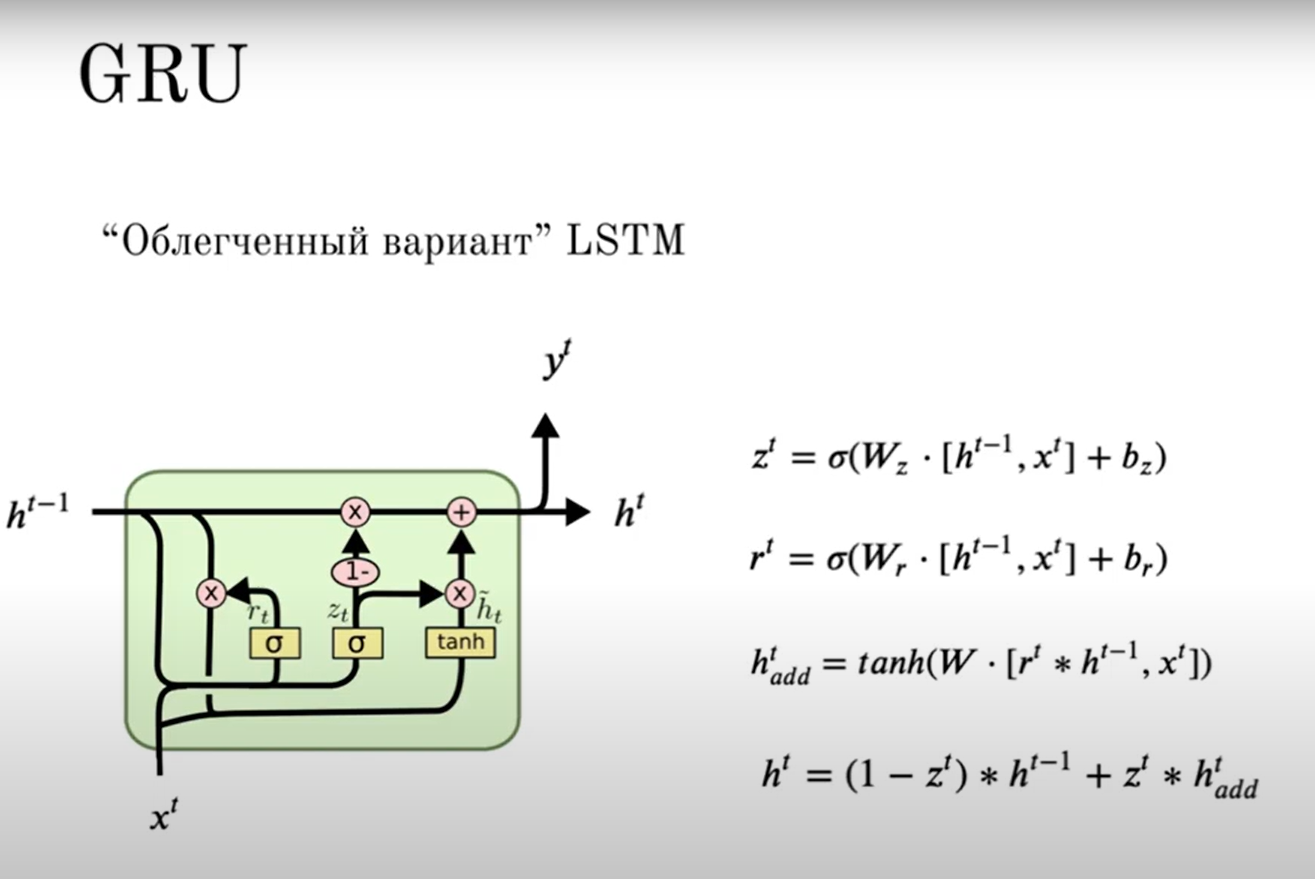

In [25]:
display(Image("Images/4 GRU.png"))


#### GRU: Расчет на временном шаге t и слое l

#### 1) Reset Gate (Ворота сброса)
$r_t = σ(W_ir * x_t + b_ir + W_hr * h_{t-1} + b_hr)$  

#### Что делает: Определяет, какую часть информации из прошлого состояния h_{t-1} нужно "забыть".
#### Пример: Если r_t ≈ 0, то прошлая информация почти игнорируется.

#### 2) Update Gate (Ворота обновления)
$z_t = σ(W_iz * x_t + b_iz + W_hz * h_{t-1} + b_hz)$
#### Что делает: Контролирует, сколько информации из прошлого состояния нужно оставить.
#### Пример: Если z_t ≈ 1, то сохраняется основная часть h_{t-1}.

#### 3) Candidate Hidden State (Кандидат на новое скрытое состояние)
$h̃_t = tanh(W_in * x_t + b_in + r_t ⊙ (W_hn * h_{t-1} + b_hn))$

#### Что делает: Создает "кандидат" на новое состояние, учитывая текущий вход и прошлое состояние,
####             прошедшее через reset gate ($r_t$).

#### Примечание: tanh добавляет нелинейность в диапазоне [-1, 1].

#### 4) Final Hidden State (Итоговое скрытое состояние)
$h_t = (1 - z_t) ⊙ h_{t-1} + z_t ⊙ h̃_t$
#### Что делает: Комбинирует прошлое состояние и новое, используя update gate.
#### Пример: Если $z_t$ ≈ 0, то сохраняется $h_{t-1}$; если $z_t$ ≈ 1, то берется $h̃_t$.

#### Применение GRU

In [26]:
class NameGenderClassifier_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(NameGenderClassifier_GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, 
                         hidden_size, 
                         num_layers, 
                         batch_first=True)  # GRU вместо RNN
        self.fc = nn.Linear(hidden_size, 1)
        # Сигмоиду оставляем в forward для явного контроля

    def forward(self, x):
        # Встраивание
        x = self.embedding(x)
        
        # GRU с автоматическим учётом длин (если нужно - можно добавить pack_padded_sequence)
        out, _ = self.gru(x)  # out: [batch_size, seq_len, hidden_size]
        
        # Берём последний скрытый состояние
        out = out[:, -1, :]  # [batch_size, hidden_size]
        
        # Полносвязный слой + сигмоида
        return torch.sigmoid(self.fc(out))

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Гиперпараметры
vocab_size = len(id_to_token)
embedding_dim = 5#13
hidden_size = 5
num_layers = 1
num_epochs = 10  # Количество эпох
learning_rate = 0.001

# Создаем модель
model_GRU = NameGenderClassifier_GRU(vocab_size, embedding_dim, hidden_size, num_layers).to(device)
criterion = nn.BCELoss()  # Бинарная кросс-энтропия
optimizer = optim.Adam(model_GRU.parameters(), lr=learning_rate)

In [28]:
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for name, length, gender in train_loader:
        name = name.to(device)
        gender = gender.float().to(device)  # Переводим в float, так как BCE требует float-метки
        
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model_GRU(name).squeeze()  # (batch_size, 1) -> (batch_size,)
        loss = criterion(outputs, gender)
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем веса
        
        total_loss += loss.item()
        
        # Оценка точности
        predicted = (outputs > 0.5).float()  # Округляем вероятности (0 или 1)
        correct += (predicted == gender).sum().item()
        total += gender.size(0)

    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/10], Loss: 117.9605, Accuracy: 0.4990
Epoch [2/10], Loss: 117.2174, Accuracy: 0.5698
Epoch [3/10], Loss: 108.5651, Accuracy: 0.6721
Epoch [4/10], Loss: 95.6514, Accuracy: 0.7211
Epoch [5/10], Loss: 86.5819, Accuracy: 0.7606
Epoch [6/10], Loss: 80.8272, Accuracy: 0.7847
Epoch [7/10], Loss: 78.1602, Accuracy: 0.7897
Epoch [8/10], Loss: 76.4015, Accuracy: 0.7996
Epoch [9/10], Loss: 75.2700, Accuracy: 0.8028
Epoch [10/10], Loss: 74.7047, Accuracy: 0.8066


In [29]:
# Пример использования
train_auc = calculate_auc(train_dataset, model_GRU, device)
valid_auc = calculate_auc(valid_dataset, model_GRU, device)
test_auc = calculate_auc(test_dataset, model_GRU, device)

print(f"Train AUC: {train_auc:.4f}")
print(f"Valid AUC: {valid_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Train AUC: 0.8822
Valid AUC: 0.8664
Test AUC: 0.8882


### 4 LSTM (Long Short Term Memory)

#### Все равно есть проблема забывания  

#### Очень тяжелый слой, так как много разных функций активаций и нужно дольше считать и forward и backward на каждом шаге

#### Определение 
Длинная цепь элементов краткосрочной памяти (англ. Long short-term memory; LSTM) — разновидность архитектуры рекуррентных нейронных сетей, предложенная в 1997 году Зеппом Хохрайтером и Юргеном Шмидхубером[2].

#### Часто применялась до 2017-го года

#### Общая схема  
Главное отличие от обычной RNN это то что здесь помимо вектора **h** есть ещё и верхний канал **C**, который сохраняет важный долгосрочный контент

Длина $h_{t}$ - количество нейронов которые мы укажем при обучении LSTM(128)  
$h_{t}$ это и есть выходы из LSTM

### $C^{t}$ - "долгосрочная память"  
### $h^{t}$ - "краткосрочная память"  
### Оба вектора имеют такой же рамзер как и $x_{t}$  

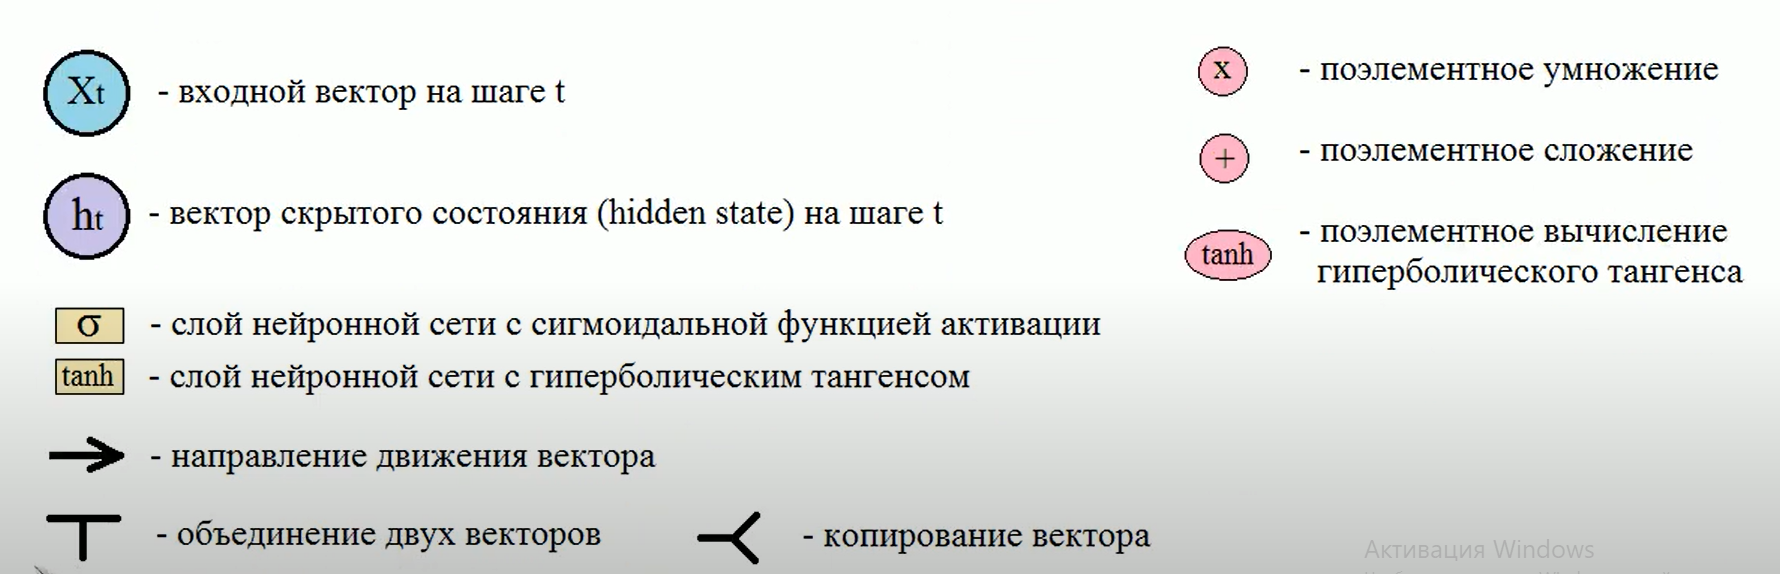

In [30]:
display(Image("Images/23_LSTM.png"))

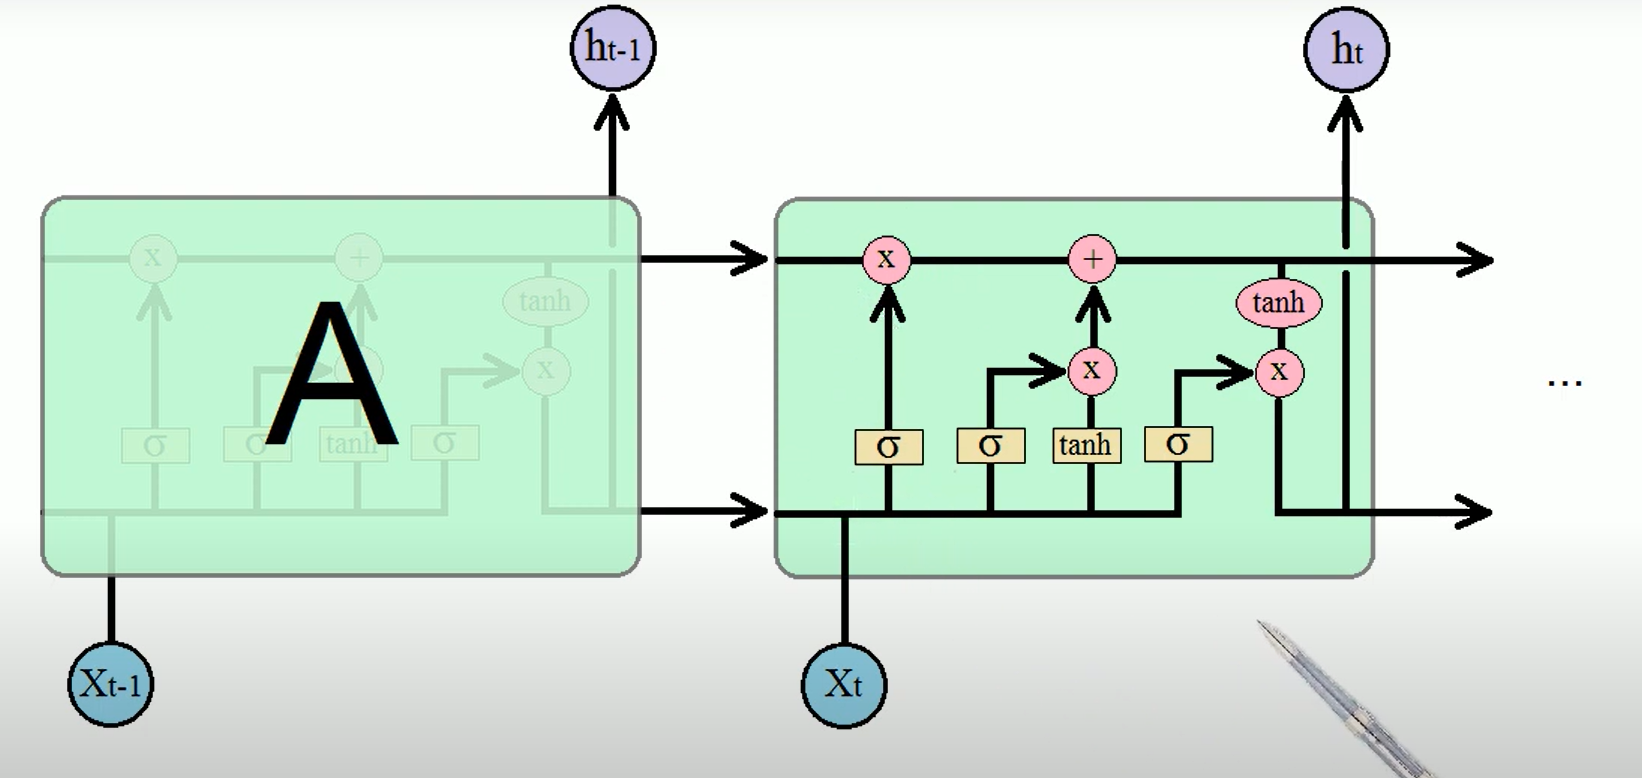

In [31]:
display(Image("Images/22_LSTM.png"))

#### Ещё одна общая схема

На вход в рекуррентный слов подаются два вектора $C_{t-1}$ и $h_{t-1}$ с задержкой по времени "1 такт"

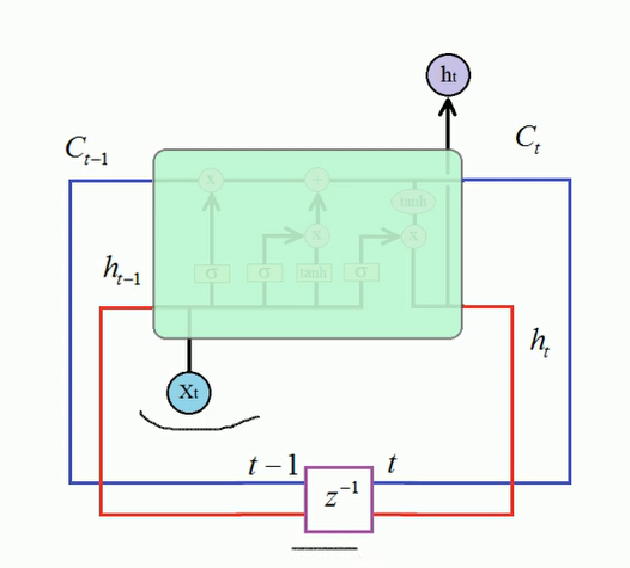

In [32]:
display(Image("Images/27_LSTM.png"))

#### 1) "Забывание ненужного" (Ворота забывания - forget gate)

1) Вначале у нас идёт сложение векторов $h_{t-1}$ и $x_{t}$, сложение имеется ввиду что теперь у нас получается вектор длиной суммы длины обоих этих векторов, например, $h_{t-1}$ = [1,2,3] и $x_{t}$ = [4,5], тогда $[h_{t-1},x_{t}]$ = [1,2,3,4,5]  
2) Умножаем его на веса $W_{f}$ и прибавляем байес $b_{f}$ и Оборачиваем в сигмойду    
Получаем вектор $f_{t}$ со значениями от 0 до 1, например, $f_{t} = [0.2,0.3,0.9,0.1,0.5,...]^{T}$. Эти числа можно воспринимать как некие веса того, какие компоненты в долгосрочном контенте $С_{t-1}$ оставить, а что забыть  
3) Умножаем поэлементно наш $C_{t-1}$ на $f_{t}$   
Что оставить а что нет, это всё проявляется в процессе обучения  
Получается часть информации стирается, так как мы умножаем $C_{t-1}$ на $f_{t}$ где каждый элемент меньше 1  

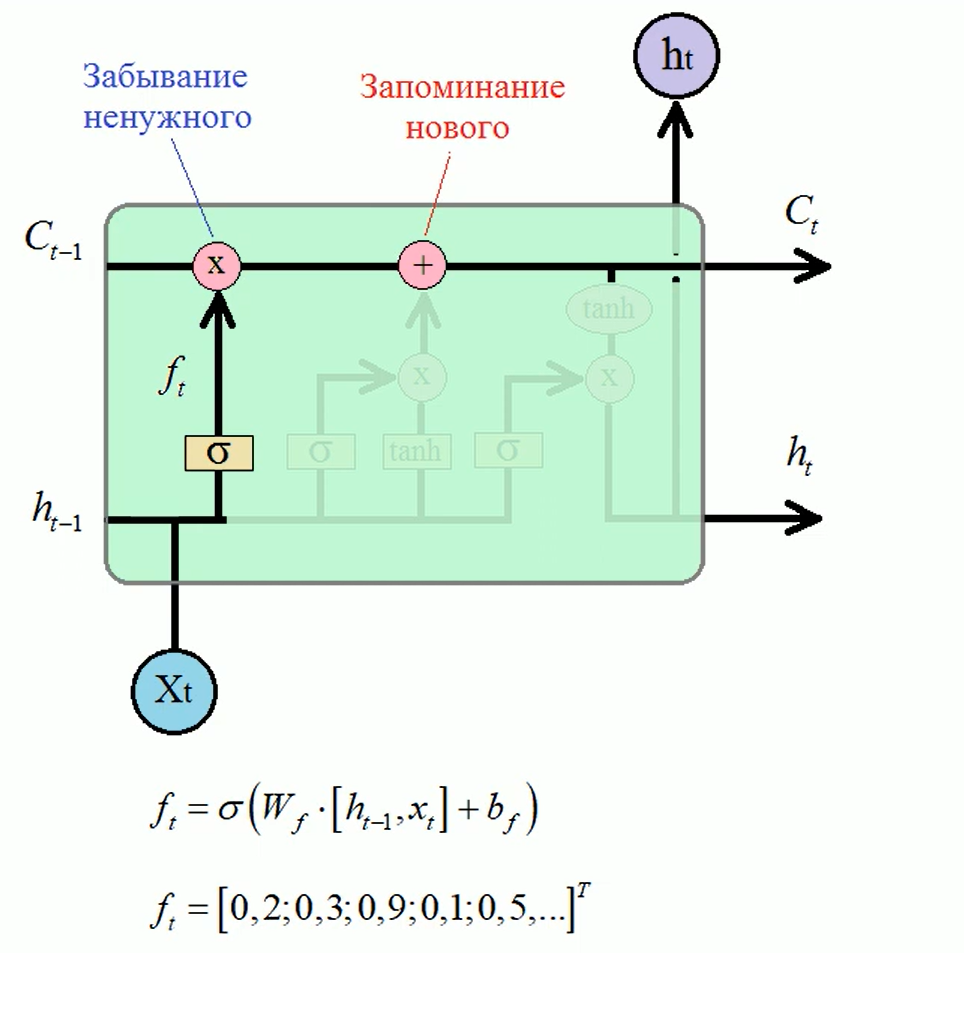

In [33]:
display(Image("Images/24_LSTM.png"))

#### 2) "Запоминание нового" (Входные ворота - Input gate)  

1) Соединяем векторы $x_{t}$ и $h_{t-1}$, берём **σ**, считаем $i_{t}$  
$i_{t}$ говорит что убрать а что оставить в векторе $\tilde{C}_{t}$  
Это как бы вектор веса для пунтка 2(ниже), который определяет какую часть вектора $\tilde{C}_{t-1}$ мы хотим добавить  

2) **$\tilde{C}_{t-1}$:** Соединяем векторы $x_{t}$ и $h_{t-1}$, берём **tahn**, считаем $\tilde{C}_{t-1}$ **(промежуточный вектор контента)**  

на выходе получаем компоненты вектора от -1 до 1    

Это говорит о том какую дополнительную информацию важно добавить в вектор долгосрочной памяти  

В итоге мы оставляем новое важное и это новое важное добавляем в долгосрочный вектор контента $C_{t}$ благодаря поэлементному сложению  

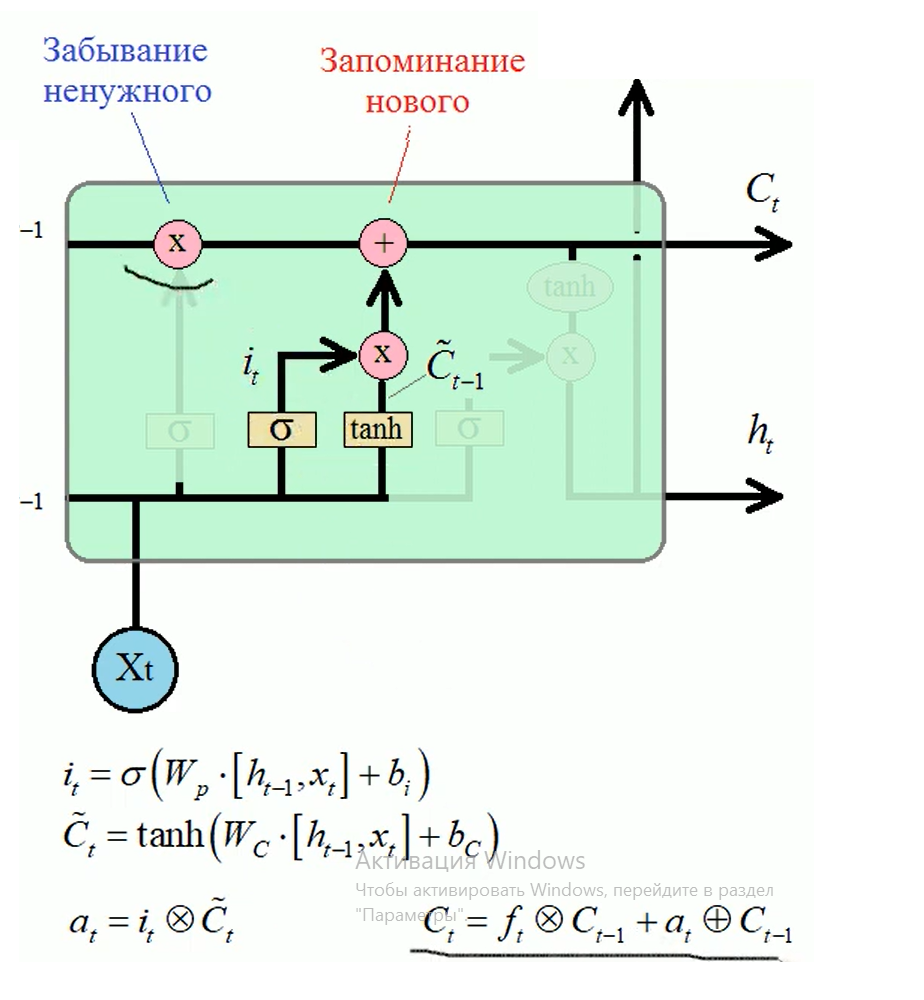

In [34]:
display(Image("Images/25_LSTM.png"))

#### 3) Формирование скрытого  состояния $h_{t}$

1) Соединяем векторы $x_{t}$ и $h_{t-1}$, берём **σ**, считаем оценочный вектор $o_{t}$  
2) Вектор долгосрочной памяти $C_{t}$ нормируется при помощи гиперболического тангенса $tahn$    
3) Получаем $h_{t}$ путём поэлементного перемножения $o_{t}$ и $C_{t}$   

В итоге часть берем информации из долгосрочной памяти **$С_{t}$** и применяем ее к краткосрочной памяти **$h_{t}$**

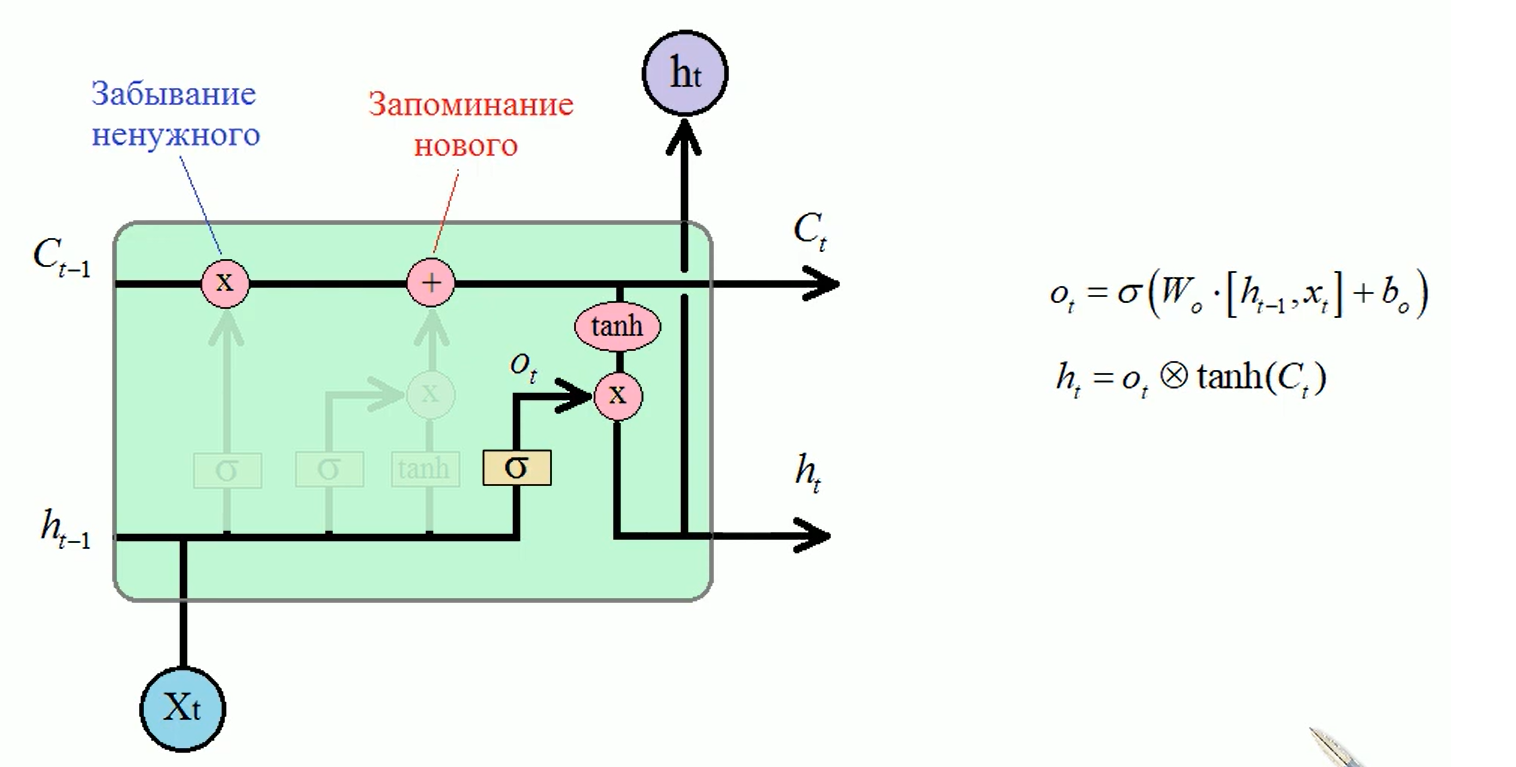

In [35]:
display(Image("Images/26_LSTM.png"))

### Применение LSTM

In [36]:
class NameGenderClassifier_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(NameGenderClassifier_LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_size, 
                           num_layers, 
                           batch_first=True)  # LSTM вместо RNN/GRU
        self.fc = nn.Linear(hidden_size, 1)
        # Сигмоида остаётся в forward

    def forward(self, x, lengths=None):
        # Встраивание
        x = self.embedding(x)
        
        # Обработка длин последовательностей (опционально)
        if lengths is not None:
            x = nn.utils.rnn.pack_padded_sequence(x, lengths, 
                                                batch_first=True, 
                                                enforce_sorted=False)
        
        # LSTM layer
        out, (hidden, cell) = self.lstm(x)  # out: [batch, seq_len, hidden_size]
        
        # Распаковка (если использовали pack_padded_sequence)
        if lengths is not None:
            out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        
        # Берём последнее скрытое состояние
        out = out[:, -1, :]  # Или можно использовать hidden[-1]
        
        # Классификация
        return torch.sigmoid(self.fc(out))

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Гиперпараметры
vocab_size = len(id_to_token)
embedding_dim = 5#13
hidden_size = 5
num_layers = 1
num_epochs = 10  # Количество эпох
learning_rate = 0.001

# Создаем модель
model_LSTM = NameGenderClassifier_LSTM(vocab_size, embedding_dim, hidden_size, num_layers).to(device)
criterion = nn.BCELoss()  # Бинарная кросс-энтропия
optimizer = optim.Adam(model_LSTM.parameters(), lr=learning_rate)

In [38]:
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for name, length, gender in train_loader:
        name = name.to(device)
        gender = gender.float().to(device)  # Переводим в float, так как BCE требует float-метки
        
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model_LSTM(name).squeeze()  # (batch_size, 1) -> (batch_size,)
        loss = criterion(outputs, gender)
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем веса
        
        total_loss += loss.item()
        
        # Оценка точности
        predicted = (outputs > 0.5).float()  # Округляем вероятности (0 или 1)
        correct += (predicted == gender).sum().item()
        total += gender.size(0)

    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/10], Loss: 119.1102, Accuracy: 0.4979
Epoch [2/10], Loss: 114.5862, Accuracy: 0.5985
Epoch [3/10], Loss: 102.5400, Accuracy: 0.7019
Epoch [4/10], Loss: 94.1781, Accuracy: 0.7454
Epoch [5/10], Loss: 89.9263, Accuracy: 0.7571
Epoch [6/10], Loss: 86.6562, Accuracy: 0.7692
Epoch [7/10], Loss: 83.6907, Accuracy: 0.7830
Epoch [8/10], Loss: 81.3778, Accuracy: 0.7840
Epoch [9/10], Loss: 79.6270, Accuracy: 0.7888
Epoch [10/10], Loss: 78.5251, Accuracy: 0.7900


In [39]:
# Пример использования
train_auc = calculate_auc(train_dataset, model_LSTM, device)
valid_auc = calculate_auc(valid_dataset, model_LSTM, device)
test_auc = calculate_auc(test_dataset, model_LSTM, device)

print(f"Train AUC: {train_auc:.4f}")
print(f"Valid AUC: {valid_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Train AUC: 0.8676
Valid AUC: 0.8542
Test AUC: 0.8818
